# BINOSNP ANALYSIS

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multicomp as mc
from scipy import stats
import pickle
from scipy.stats import mannwhitneyu as mannwu
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import scipy.stats as sstats
from scipy.stats import false_discovery_control
from matplotlib.ticker import LogLocator, LogFormatterMathtext

import sys
sys.path.append("./scripts/modules")

from benchmarking_definitions import *
from plotting import *

In [2]:
tagsRv = pd.read_csv("./data/source/FINAL_tag_list.csv", names=["tag"])["tag"].values
tagsL1234 = pd.read_csv("./data/source/FINAL_tag_list_L1234.csv", names=["tag"]).tag.values

len(tagsRv), len(tagsL1234)

(2500, 1000)

# Time analysis

In each scratch directory run:
```
cat *.err | grep real | awk '{print $2}' > /home/sm624/projects/mixed_calls/benchmarking/binosnp/_time_trial/time_trial_1x_times.csv
```

In [3]:
binosnp_time_results = pd.DataFrame(columns=["time_hours", "num_pos"])
df_i = 0

for num_pos in [10, 100, 1_000, 10_000, 100_000]:
    
    time_df = pd.read_csv("./data/binosnp_analysis/time_trial_{0}_times.csv".format(num_pos), sep=" ",
                         names=["time"])
            
    for i in time_df.index:
        time = time_df.loc[i, "time"]
        mins, secs = float(time.split("m")[0]), float(time.split("m")[1].strip("s"))
        total_time_hours = (mins*60 + secs)/3600
        binosnp_time_results.loc[df_i] = [total_time_hours, int(num_pos)]
        df_i += 1
    
    binosnp_time_results["num_pos"] = binosnp_time_results["num_pos"].astype(int)

In [4]:
binosnp_time_results

,time_hours,num_pos
0,0.001242,10
1,0.001025,10
2,0.001026,10
3,0.001103,10
4,0.001102,10
...,...,...
2495,7.968550,100000
2496,7.776057,100000
2497,7.775163,100000
2498,7.776446,100000


In [5]:
binosnp_time_results.loc[2500] = [5*24, 1_000_000]

In [6]:
for i, group in binosnp_time_results.groupby("num_pos"):
    print(i)
    mean_time = group.time_hours.mean()
    if mean_time < 1:
        print(mean_time*60, "mins")
    else:
        print(mean_time, "hrs")
    print()


10
0.06448203333333336 mins

100
0.46063333333333334 mins

1000
4.7328505000000005 mins

10000
48.066359766666665 mins

100000
8.460674098888889 hrs

1000000
120.0 hrs



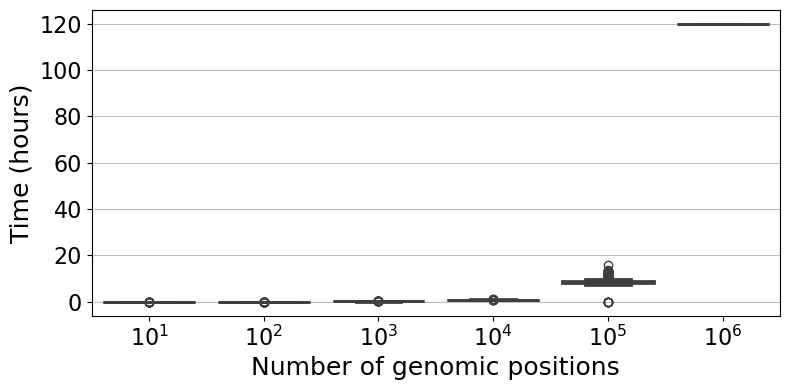

In [37]:
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=binosnp_time_results, x="num_pos", y="time_hours", linewidth=2)

ax.tick_params(labelsize=16)
ax.grid(axis="y", linewidth=0.6, zorder=1)

ax.set_xlabel("Number of genomic positions", fontsize=18)
ax.set_ylabel("Time (hours)", fontsize=18)

ax.set_yticks(np.arange(0, 121, 20))
ax.set_yticklabels(np.arange(0, 121, 20))

ax.tick_params(axis="x")

ticks = [10**i for i in range(1, 7)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([rf"$10^{i}$" for i in range(1, 7)])


plt.tight_layout()

file_name = "./figures/binosnp_analysis/binosnp_times_boxplot.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_analysis/binosnp_times_boxplot.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# FP found by at least one other variant caller that are also found by BinoSNP

Determine the ability of BinoSNP to weed out FP

In [9]:
binosnp_FP_analysis = pd.read_csv("./data/binosnp_analysis/ISS_binosnp_FP_analysis.csv")
binosnp_FP_analysis.head()

,genome,tag,depth,num_FP_one_other_tool,num_FP_BS,percentage_FP_BS_found
0,H37Rv,sim1_h37rv_mutant_1_50_0.01,50,328,314,95.731707
1,H37Rv,sim1_h37rv_mutant_2_50_0.01,50,293,279,95.221843
2,H37Rv,sim1_h37rv_mutant_3_50_0.01,50,314,299,95.222930
3,H37Rv,sim1_h37rv_mutant_4_50_0.01,50,306,291,95.098039
4,H37Rv,sim1_h37rv_mutant_5_50_0.01,50,324,310,95.679012


## Total percentage of FP found by BinoSNP

In [10]:
binosnp_FP_analysis.percentage_FP_BS_found.mean()

np.float64(85.06928279236463)

In [11]:
valid_min_vals = []

for i in binosnp_FP_analysis.index:

    if binosnp_FP_analysis.loc[i, "num_FP_one_other_tool"] != 0:
        if binosnp_FP_analysis.loc[i, "num_FP_BS"] != 0:
            valid_min_vals.append(binosnp_FP_analysis.loc[i, "percentage_FP_BS_found"])

np.min(valid_min_vals)

np.float64(33.33333333333333)

## Difference by background genome

In [12]:
binosnp_FP_analysis_no_na = binosnp_FP_analysis.dropna()

In [13]:
test_lineages = binosnp_FP_analysis_no_na.genome.unique()
lineage_combos = list(combinations(test_lineages, 2))

In [18]:
all_tools_results_df = pd.DataFrame(columns=["lineage1", "lineage2", "lineage2-lineage1_mean_diff", "p_val"])
df_i = 0

for lineage1, lineage2 in lineage_combos:

    lineage1_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.genome == lineage1]["percentage_FP_BS_found"].values
    lineage2_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.genome == lineage2]["percentage_FP_BS_found"].values
    
    test_result = mannwu(lineage1_values, lineage2_values)

    all_tools_results_df.loc[df_i] = [lineage1, lineage2, np.mean(lineage2_values)-np.mean(lineage1_values), test_result[1]]
    df_i += 1

raw_pvalues = all_tools_results_df.p_val.values
corrected_pvals = false_discovery_control(raw_pvalues, method='bh')

all_tools_results_df["corrected_p_val"] = corrected_pvals
all_tools_results_df["decision"] = (np.array(corrected_pvals) <= 0.05).astype(int)

all_tools_results_df

,lineage1,lineage2,lineage2-lineage1_mean_diff,p_val,corrected_p_val,decision
0,H37Rv,L1,-30.411809,5.828914e-146,2.914457e-145,1
1,H37Rv,L2,-31.836082,3.904380e-146,2.914457e-145,1
2,H37Rv,L3,-29.817728,1.656916e-145,5.523053e-145,1
3,H37Rv,L4,-28.907476,4.326135e-145,1.081534e-144,1
4,L1,L2,-1.424273,2.239276e-06,3.198966e-06,1
5,L1,L3,0.594081,5.882548e-01,5.882548e-01,0
6,L1,L4,1.504333,2.736125e-02,3.420157e-02,1
7,L2,L3,2.018354,1.359301e-07,2.265502e-07,1
8,L2,L4,2.928606,5.379636e-10,1.075927e-09,1
9,L3,L4,0.910252,1.335396e-01,1.483774e-01,0


In [19]:
Rv_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.genome == "H37Rv"]["percentage_FP_BS_found"].values
L1234_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.genome.isin(["L{}".format(i) for i in range(1, 5)])]["percentage_FP_BS_found"].values

print("H37Rv average % FP found by BinoSNP: {}".format(np.mean(Rv_values)))
print("L1234 average % FP found by BinoSNP: {}".format(np.mean(L1234_values)))

mannwu(Rv_values, L1234_values)

H37Rv average % FP found by BinoSNP: 93.83290887598882
L1234 average % FP found by BinoSNP: 63.5896352614017


MannwhitneyuResult(statistic=np.float64(2428891.0), pvalue=np.float64(0.0))

In [33]:
np.float64(mannwu(Rv_values, L1234_values)[1])

np.float64(0.0)

In [20]:
for lineage in test_lineages:

    lineage_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.genome == lineage]["percentage_FP_BS_found"].values

    print("{}: average = {}%".format(lineage, np.mean(lineage_values)))

H37Rv: average = 93.83290887598882%
L1: average = 63.421100114872694%
L2: average = 61.996826851875724%
L3: average = 64.01518096194198%
L4: average = 64.92543311691644%


In [21]:
lineage_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.genome.isin(["L{}".format(i) for i in range(1, 5)])]["percentage_FP_BS_found"].values

print("{}: average = {}%".format(lineage, sstats.sem(lineage_values)))

L4: average = 0.17304814244907252%


## Difference by depth

In [22]:
for depth in depths:

    depth_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.depth == depth]["percentage_FP_BS_found"].values

    print("{}x: average = {}%".format(depth, np.mean(depth_values)))

50x: average = 86.14773073654207%
100x: average = 87.8158205878397%
200x: average = 82.38055183651271%
400x: average = 84.5817464747367%
700x: average = 84.37365395792526%


In [23]:
depth_combos = list(combinations(depths, 2))

In [35]:
all_tools_results_df = pd.DataFrame(columns=["depth1", "depth2", "depth2-depth1_mean_diff", "p_val"])
df_i = 0

for depth1, depth2 in depth_combos:

    depth1_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.depth == depth1]["percentage_FP_BS_found"].values
    depth2_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.depth == depth2]["percentage_FP_BS_found"].values
    
    test_result = mannwu(depth1_values, depth2_values)

    all_tools_results_df.loc[df_i] = [depth1, depth2, np.mean(depth2_values)-np.mean(depth1_values), test_result[1]]
    df_i += 1

raw_pvalues = all_tools_results_df.p_val.values
corrected_pvals = false_discovery_control(raw_pvalues, method='bh')

all_tools_results_df["corrected_p_val"] = corrected_pvals
all_tools_results_df["decision"] = (np.array(corrected_pvals) <= 0.05).astype(int)

all_tools_results_df

,depth1,depth2,depth2-depth1_mean_diff,p_val,corrected_p_val,decision
0,50.0,100.0,-1.387710,1.138605e-10,1.423257e-10,1
1,50.0,200.0,-6.423242,1.144074e-37,1.144074e-36,1
2,50.0,400.0,-11.718621,2.282856e-26,7.609519e-26,1
3,50.0,700.0,-12.425412,9.090682e-31,4.545341e-30,1
4,100.0,200.0,-5.035532,6.518460e-19,1.303692e-18,1
5,100.0,400.0,-10.330911,7.509285e-16,1.251548e-15,1
6,100.0,700.0,-11.037703,1.480756e-20,3.701889e-20,1
7,200.0,400.0,-5.295379,1.050787e-07,1.167542e-07,1
8,200.0,700.0,-6.002171,4.816248e-11,6.880355e-11,1
9,400.0,700.0,-0.706792,4.006872e-04,4.006872e-04,1


## Difference by region

In [25]:
binosnp_FP_by_region_analysis = pd.read_csv("./data/binosnp_analysis/ISS_binosnp_FP_by_region_analysis.csv")
binosnp_FP_by_region_analysis.head()

,genome,tag,depth,region,num_FP_one_other_tool,num_FP_BS,percentage_FP_BS_found
0,H37Rv,sim1_h37rv_mutant_1_50_0.01,50,DR,1,1,100.000000
1,H37Rv,sim1_h37rv_mutant_1_50_0.01,50,HT,0,0,NaN
2,H37Rv,sim1_h37rv_mutant_1_50_0.01,50,LM,24,22,91.666667
3,H37Rv,sim1_h37rv_mutant_1_50_0.01,50,other,303,291,96.039604
4,H37Rv,sim1_h37rv_mutant_2_50_0.01,50,DR,3,3,100.000000


In [26]:
binosnp_FP_analysis_no_na = binosnp_FP_by_region_analysis.dropna()

In [27]:
for region in regions_other:

    region_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.region == region]["percentage_FP_BS_found"].values

    print("{}: average = {}%".format(region, np.mean(region_values)))

DR: average = 90.20288498005009%
HT: average = 6.51923408996585%
LM: average = 85.07314854155719%
other: average = 85.17348464224038%


In [28]:
for region in regions_other:

    region_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.region == region]["percentage_FP_BS_found"].values

    print("{}: average = {}%".format(region, np.median(region_values)))

DR: average = 91.95979899497488%
HT: average = 5.169793522691542%
LM: average = 93.20388349514565%
other: average = 90.68589743589743%


In [29]:
region_combos = list(combinations(regions_other, 2))

In [30]:
all_tools_results_df = pd.DataFrame(columns=["region1", "region2", "region2-region1_mean_diff", "p_val"])
df_i = 0

for region1, region2 in region_combos:

    region1_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.region == region1]["percentage_FP_BS_found"].values
    region2_values = binosnp_FP_analysis_no_na[binosnp_FP_analysis_no_na.region == region2]["percentage_FP_BS_found"].values
    
    test_result = mannwu(region1_values, region2_values)

    all_tools_results_df.loc[df_i] = [region1, region2, np.mean(region2_values)-np.mean(region1_values), test_result[1]]
    df_i += 1

raw_pvalues = all_tools_results_df.p_val.values
corrected_pvals = false_discovery_control(raw_pvalues, method='bh')

all_tools_results_df["corrected_p_val"] = corrected_pvals
all_tools_results_df["decision"] = (np.array(corrected_pvals) <= 0.05).astype(int)

all_tools_results_df

,region1,region2,region2-region1_mean_diff,p_val,corrected_p_val,decision
0,DR,HT,-83.683651,0.000000e+00,0.000000e+00,1
1,DR,LM,-5.129736,2.902862e-24,3.483434e-24,1
2,DR,other,-5.029400,2.061125e-85,3.091688e-85,1
3,HT,LM,78.553914,0.000000e+00,0.000000e+00,1
4,HT,other,78.654251,0.000000e+00,0.000000e+00,1
5,LM,other,0.100336,9.923996e-18,9.923996e-18,1
